# Databased used
- CREMA-D: 7,442 clips
- RAVDESS: 2,880 clips
- TESS: 2,000 clips
- SAVEE: 480 clips

This provides a total of **12,802** inputs overall, with 7 emotions (anger, disgust, fear, happy, neutral, sad, suprise).

In [71]:
# Import libraries
# KERNEL SETUP IN VS CODE:
# conda create -n myenv python=3.12.2
# conda activate myenv

%pip install resampy tf_keras tensorflow librosa pandas matplotlib kagglehub seaborn

import kagglehub
import librosa
from librosa import feature
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Datasets via kagglehub

cremad = kagglehub.dataset_download("ejlok1/cremad")
print("CREMA-D to dataset files:", cremad)

ravdess = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("RAVDESS to dataset files:", ravdess)

tess = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("RAVDESS to dataset files:", tess)

savee = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
print("RAVDESS to dataset files:", savee)

# Pre-processing
## CREMA-D

In [ ]:
# Load CREMA-D Dataset
paths = []
emotions = []

for dirname, _, filenames in os.walk(cremad): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            emotion = filename.split('_')[2]  # Get the emotion code (e.g., 'ANG')
            emotions.append(emotion)

print(paths[:5])

print(emotions[:5])

# Create DataFrame
cremad_df = pd.DataFrame()
cremad_df['paths'] = paths
cremad_df['emotions'] = emotions

# Map emotion codes to full emotions
emotion_map = {
    'ANG': 'anger',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

cremad_df['emotions'] = cremad_df['emotions'].map(emotion_map)

print(cremad_df.head())

print(cremad_df['emotions'].value_counts())

## RAVEDESS

In [83]:
paths = []
emotions = []

for dirname, _, filenames in os.walk(ravdess): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            part = filename.split('.')[0].split('-')  # Get the emotion number (e.g., '03' = happy)
            emotions.append(int(part[2]))


print(paths[:5])
print(emotions[:5])

# Create DataFrame
ravdess_df = pd.DataFrame()
ravdess_df['paths'] = paths
ravdess_df['emotions'] = emotions


# Map emotion codes to full emotions
emotion_map = {
    1 : 'neutral',
    2 : 'neutral', # calm as neutral to balance dataset
    3 : 'happy',
    4 : 'sad',
    5 : 'anger',
    6 : 'fear',
    7 : 'disgust',
    8 : 'suprise'

}

ravdess_df['emotions'] = ravdess_df['emotions'].map(emotion_map)

print(ravdess_df.head())

print(ravdess_df['emotions'].value_counts())

['C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-01-01-01-01-01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-01-01-01-02-01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-01-01-02-01-01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-01-01-02-02-01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-02-01-01-01-01.wav']
[1, 1, 1, 1, 2]
                                               paths emotions
0  C:\Users\eskillman\.cache\kagglehub\datasets\u...  neutral
1  C:\Users\eskillman\.cache\kagglehub\datasets\u...  neutral
2  C:\Users\eskillman\.cache\kagglehub\datasets\u...  neutral


## TESS

In [84]:
paths = []
emotions = []

for dirname, _, filenames in os.walk(tess): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            emotion = filename.split('.')[0].split('_')[2]  # Get the emotion code (e.g., 'ANG')
            emotions.append(emotion)

print(paths[:5])

print(emotions[:5])

# Create DataFrame
tess_df = pd.DataFrame()
tess_df['paths'] = paths
tess_df['emotions'] = emotions

# Map emotion codes to full emotions
emotion_map = {
    'angry': 'anger',
    'disgust': 'disgust',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'ps' : 'suprise',
    'sad' : 'sad'
}

tess_df['emotions'] = tess_df['emotions'].map(emotion_map)

print(tess_df.head())

print(tess_df['emotions'].value_counts())

['C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']
['angry', 'angry', 'angry', 'angry', 'angry']
                                               paths e

## SAVEE

In [85]:
paths = []
emotions = []

for dirname, _, filenames in os.walk(savee): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            part = filename.split('_')[1]  # Get the emotion code (e.g., 'ANG')
            emotion = part[:-6]
            emotions.append(emotion)

print(paths[:5])

print(emotions[:5])

# Create DataFrame
savee_df = pd.DataFrame()
savee_df['paths'] = paths
savee_df['emotions'] = emotions

emotion_map = {
    'n': 'neutral',
    'd': 'disgust',
    'a': 'anger',
    'f': 'fear',
    'h': 'happy',
    'sa': 'sad',
    'su' : 'suprise'
}

savee_df['emotions'] = savee_df['emotions'].map(emotion_map)

print(savee_df.head())

print(savee_df['emotions'].value_counts())

['C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a02.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a03.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a04.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a05.wav']
['a', 'a', 'a', 'a', 'a']
                                               paths emotions
0  C:\Users\eskillman\.cache\kagglehub\datasets\e...    anger
1  C:\Users\eskillman\.cache\kagglehub\datasets\e...    anger
2  C:\Users\eskillman\.cache\kagglehub\datasets\e...    anger
3  C:\Users\eskillman\.cache\kagglehub\datasets\e.

In [86]:
emotion_data = pd.concat([cremad_df, ravdess_df, tess_df, savee_df], axis = 0)

emotion_data.to_csv("emotion_data.csv", index=False)

print(emotion_data.emotions.value_counts())

emotions
neutral    2583
disgust    2515
anger      2515
fear       2515
happy      2515
sad        2515
suprise    1244
Name: count, dtype: int64


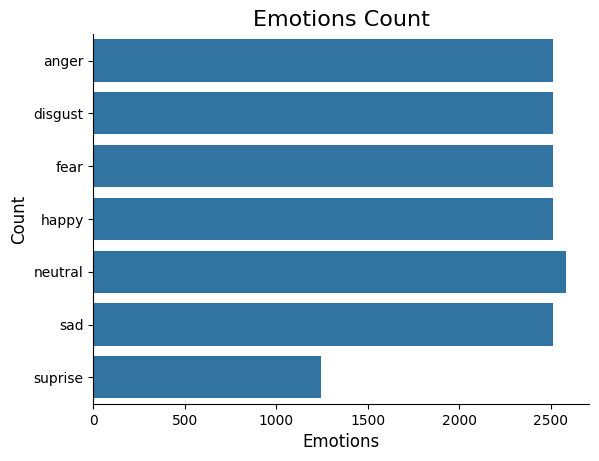

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Emotions Count', size=16)
sns.countplot(emotion_data.emotions)
plt.xlabel('Count', size=12)
plt.ylabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()